motivation, related work (λιγότερο), δεδομένα, αποτελέσματα και conclusions/contribution

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity

/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/speaker-similarity


In [ ]:
!pip3 install librosa
!pip3 install pyAudioAnalysis
!pip3 install eyed3
!pip3 install pydub

# Introduction

Speaker recognition is the task of identifying a speaker using their voice. Speaker recognition is classified into two parts: speaker identification and speaker verification. Speaker identification is the process of determining from which of the registered speakers a given utterance comes. Speaker identification requires comparison of one model to N speaker models.

In speaker identification, an utterance from an unknown speaker is analyzed and compared with speech models of known speakers. The unknown speaker is identified as the one whose model best matches the input utterance.  In identification, the number of decision alternatives is equal to the size of the population.

## Motivation

Speaker identification is finding broader use with the development of IoT and technology. It  could be used in adaptive user interfaces. For instance, a car shared by many people of the same family could recognize the driver by his/her
voice, and tune the radio to his/her favorite channel. Another instance, that could be used is in house automation. Each family member has his/her own settings in the house appliances.

In this concept, we find building more robust speaker identification applications very useful as the use of it becomes broader.

In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from app.website.extract_features import extract_mfcc, zero_crossing_rate, get_audio_info

2.6.0


## VoxCeleb dataset

VoxCeleb is an audio-visual dataset consisting of short clips of human speech, extracted from interview videos uploaded to YouTube. It is a large scale audio-visual dataset of human speech and contains speakers spanning a wide range of different ethnicities, accents, professions and ages.

We used the VoxCeleb1 dataset which contains over 100,000 utterances for 1,251 celebrities, extracted from videos uploaded to YouTube

Check given directory to find all available *.wav* files.

In [ ]:
# helper
def contains_number(s):
    return any(i.isdigit() for i in s)

In [ ]:
#check source directory and find classes
source_dir = '/content/drive/MyDrive/Multimodal_machine_learning/Speaker_identification/VoxCeleb1_dataset/Audio_files/vox1_dev_wav_subsampling/wav'
# source_dir = './audio/'
speakers = [name for name in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, name))]
print(speakers)
raw = []
for speaker in speakers:
    path = os.path.join(source_dir, speaker) + '/'
    print('checking dir:', path)
    folders = [f for f in os.listdir(path) if not f.startswith('.') ]
    for folder in folders:
        clip_path = os.path.join(path, folder) + '/'
        print(clip_path)
        clips = [f for f in os.listdir(clip_path) if f.endswith('.wav')]
        for clip in clips:
            raw.append({'speaker': speaker, 'path':clip_path+clip})

['id10087', 'id10060', 'id10056', 'id10114', 'id10055', 'id10112', 'id10054', 'id10111', 'id10110', 'id10078', 'id10108', 'id10102', 'id10094', 'id10105', 'id10103', 'id10070', 'id10101', 'id10083', 'id10069', 'id10082', 'id10100', 'id10067', 'id10098', 'id10065', 'id10064', 'id10120', 'id10037', 'id10063', 'id10117', 'id10096', 'id10116', 'id10095', 'id10093', 'id10091', 'id10090', 'id10089', 'id10088', 'id10003', 'id10068', 'id10061', 'id10092', 'id10097', 'id10057', 'id10076', 'id10104', 'id10113', 'id10066', 'id10071', 'id10051', 'id10084', 'id10118', 'id10119', 'id10075', 'id10106', 'id10080', 'id10041', 'id10074', 'id10099', 'id10011', 'id10079', 'id10072', 'id10052', 'id10053', 'id10115', 'id10107', 'id10077', 'id10073', 'id10059', 'id10058', 'id10062', 'id10081', 'id10085', 'id10086', 'id10109', 'id10031', 'id10007', 'id10014', 'id10033', 'id10021', 'id10022', 'id10042', 'id10047', 'id10035', 'id10044', 'id10050', 'id10018', 'id10010', 'id10032', 'id10048', 'id10038', 'id10015'

In [ ]:
df = pd.DataFrame(raw)
df = df[:100]
print(df.shape)
df.head()

(100, 2)


,speaker,path
0,id10087,/content/drive/MyDrive/Multimodal_machine_lear...
1,id10087,/content/drive/MyDrive/Multimodal_machine_lear...
2,id10087,/content/drive/MyDrive/Multimodal_machine_lear...
3,id10087,/content/drive/MyDrive/Multimodal_machine_lear...
4,id10087,/content/drive/MyDrive/Multimodal_machine_lear...


## Preprocessing and Feuture Extraction

* We perform a split of 70% train and 30% test on each speaker.
* Then we split the dataset on 70% train and 30% validation to avoid overfit.
* We crop every clip to 2 seconds
* Then, we extract MFCC, Delta MFCC, Zero Crossing Rate and Linear Prediction Coefficients

In [ ]:
# create test dataframe, keep 0.7 of each speaker as train and 0.3 as test
train_split = 0.7
df_train_list = []
df_test_list = []
for id in df['speaker'].unique():
    speaker = df.loc[df['speaker'] == id]
    #suffle and split dataset
    speaker = speaker.sample(frac=1, replace=False, random_state=42)
    train_indices = int(round(train_split*len(speaker)))
    train = speaker[:train_indices]
    test = speaker[:len(speaker) - train_indices]
    df_train_list.append(train)
    df_test_list.append(test)

df_train = pd.concat(df_train_list)
df_test = pd.concat(df_test_list)
print(f'Train set size: {df_train.shape}, Test set size {df_test.shape}')

# sanity check, check if both train and test sets have same speakers
b = set(df_train['speaker'].unique()) == set(df_test['speaker'].unique())
b

Train set size: (70, 2), Test set size (30, 2)


True

In [ ]:
# get sample rate and clip duration for every clip
# df_train[['sr','duration']] = df_train['path'].apply(lambda p: get_audio_info(p))
# df_test[['sr','duration']] = df_test['path'].apply(lambda p: get_audio_info(p))

# df_train.head()

In [ ]:
DEFAULT_SAMPLE_RATE = 16000

def extract_lpc(clip, nr_mfcc):
    signal ,sr = librosa.load(clip, sr=DEFAULT_SAMPLE_RATE) # downsample all clips to 16KHz
    lpc_feature = librosa.lpc(signal, 12)
    #delta_feature = librosa.feature.delta(lpc_feature)
    
    # lpc_feature = np.mean(lpc_feature.T,axis=0)
    # delta_feature = np.mean(delta_feature.T, axis=0)

    # # Standardization
    # mfcc_feature = StandardScaler().fit_transform(mfcc_feature.reshape(1,-1))
    # delta_feature = StandardScaler().fit_transform(delta_feature.reshape(1,-1))

    return pd.Series([lpc_feature])

## Mel-frequency cepstral coefficients (MFCCs)

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

Mel-frequency cepstral coefficients (MFCCs) are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal spectrum. This frequency warping can allow for better representation of sound, for example, in audio compression.

MFCCs are commonly used as features in speech recognition systems. MFCCs are also increasingly finding uses in music information retrieval applications such as genre classification and audio similarity measures as in our application.

**MFCC feature extraction procedure**

* **Window the signal (Frame the signal into short frames)**

For stable acoustic characteristics, speech needs to be examined over a sufficiently short period of time. Therefore, speech analysis must always be carried out on short segments across which the speech signal is assumed to be stationary.

* **Apply Discrete Fourier transform (DFT)**

Each windowed frame is converted into magnitude spectrum by applying DFT.

* **Take the log of the magnitude**

* **Warp the frequencies on a Mel scale**

Mel spectrum is computed by passing the Fourier transformed signal through a set of band-pass filters known as Mel-filter bank. A Mel is a unit of measure based on the human ears perceived frequency. It does not correspond linearly to the physical frequency of the tone, as the human auditory system apparently does not perceive pitch linearly. The Mel scale is approximately a linear frequency spacing below 1 kHz and a logarithmic spacing above 1kHz.

Filter banks can be implemented in both time domain and frequency domain. For MFCC computation, filter banks are generally implemented in frequency domain. The center frequencies of the filters are normally evenly spaced on the frequency axis. However, in order to mimic the human ears perception, the warped axis is implemented. The most commonly used filter shaper is triangular and in some cases the Hanning filter can be found.

* **Apply the inverse Discrete cosine transform (DCT)**

Since the vocal tract is smooth, the energy levels in adjacent bands tend to be correlated. The DCT is applied to the transformed Mel frequency coefficients produces a set of cepstral coefficients. Prior to computing DCT, the Mel spectrum is usually represented on a log scale. This results in a signal in the cepstral domain with a quefrequency peak corresponding to the pitch of the signal and a number of formants representing low quefrequency peaks. Since most of the signal information is represented by the first few MFCC coefficients, the system can be made robust by extracting only those coefficients ignoring or truncating higher order DCT components.

* **Dynamic MFCC features (delta and delta-delta coefficients)**

The cepstral coefficients are usually referred to as static features, since they only contain information from a given frame. The extra information about the temporal dynamics of the signal is obtained by computing first and second derivatives of cepstral coefficients. The first-order derivative is called delta coefficients, and the second-order derivative is called delta–delta coefficients. Delta coefficients tell about the speech rate, and delta–delta coefficients provide information similar to acceleration of speech. The delta–delta coefficients are computed by taking the first-order derivative of the delta coefficients.

In our application we divided every utterance in 13 window frames and extracted MFCC, delta coefficients and zero-crossing rate features for every window frame



In [ ]:
# number of mfccs per clip
n_mfcc = splits = 13

df_train[['mfcc','delta']] = df_train['path'].apply(lambda p: extract_mfcc(p, n_mfcc))
df_test[['mfcc','delta']] = df_test['path'].apply(lambda p: extract_mfcc(p, n_mfcc))

## Zero-crossing rate (ZCR)

Zero crossing rate is the rate at which a signal changes its sign from positive to negative or vice versa within a given time frame.

Zero-crossing rate can be seen as a measure to calculate the noise of a signal. It shows higher values when noise is present. Also it reflects, the spectral characteristics of a signal. It finds use in applications such as speech-music discrimination, speech detection (as in our case) and music genre classification.

In [ ]:
# extract Zero Crossing Rate
df_train[['zcr']] = df_train['path'].apply(lambda p: zero_crossing_rate(p, splits))
df_test[['zcr']] = df_test['path'].apply(lambda p: zero_crossing_rate(p, splits))

## Linear Prediction Coefficients (LPC) 

Linear prediction is a mathematical method where future values of a discrete-time signal are estimated as a linear function of previous samples.

Linear predictive coding (LPC) is an operation used a lot in audio signal processing and speech processing for representing the spectral envelope of a digital signal of speech in a compressed way, using the information of a linear predictive model.

LPC makes the assumption that a speech signal is produced by a buzzer at the end of a tube, with often added hissing and popping sounds. Although apparently not suited, this model is actually a good estimate of the reality of how speech is implemented. The glottis does the buzz, which is characterized by its loudness and frequency. The vocal tract creates the tube, which is characterized by its resonances. These resonances give life to formants, or enhanced frequency bands in the sound produced. Hisses and pops are generated by the action of the tongue, lips and throat during sibilants and plosives.

LPC analyzes the speech signal by estimating the formants, removing their effects from the speech signal, and estimating the intensity and frequency of the remaining buzz. The process of removing the formants is called inverse filtering, and the remaining signal after the subtraction of the filtered modeled signal is called the residue.

The numbers which describe the intensity and frequency of the buzz, the formants, and the residue signal, can be stored or transmitted somewhere else. LPC synthesizes the speech signal by reversing the process: use the buzz parameters and the residue to create a source signal, use the formants to create a filter, and run the source through the filter, resulting in speech.

Because speech signals vary with time, this process is done on short chunks of the speech signal, which are called frames. Generally, 30 to 50 frames per second give an intelligible speech with good compression.

We implemented the lpc's with librosa library. Librosa etsimates the Linear Prediction Coefficients via Burg’s method. This function applies Burg’s method to estimate coefficients of a linear filter on y of order order. Burg’s method is an extension to the Yule-Walker approach, which are both sometimes referred to as LPC parameter estimation by autocorrelation.

In [ ]:
df_train[['lpc']] = df_train['path'].apply(lambda p: extract_lpc(p, n_mfcc))
df_test[['lpc']] = df_test['path'].apply(lambda p: extract_lpc(p, n_mfcc))

In [ ]:
df_train.head()

,speaker,path,mfcc,delta,zcr,lpc
22,id10087,/content/drive/MyDrive/Multimodal_machine_lear...,"[-288.2686, 76.966255, -42.058193, 2.0592701, ...","[0.044863496, -0.012586288, -0.004809206, -0.0...","[0.15460068809018374, 0.13088353707634873, 0.1...","[1.0, -1.3109238, 0.5257847, 0.028887056, 0.04..."
0,id10087,/content/drive/MyDrive/Multimodal_machine_lear...,"[-209.5218, 58.979614, 7.4156075, 34.666397, -...","[-0.16325979, -0.09911911, 0.14622329, -0.0003...","[0.13676588897827835, 0.18932689729149907, 0.0...","[1.0, -0.9609632, -0.06840864, 0.24088846, 0.0..."
49,id10087,/content/drive/MyDrive/Multimodal_machine_lear...,"[-266.17142, 79.64686, -27.390453, 15.918702, ...","[0.16107118, 0.05825362, -0.1811682, -0.038266...","[0.09056312676780663, 0.1956286963229622, 0.12...","[1.0, -1.5730263, 0.93462825, -0.3801985, 0.30..."
4,id10087,/content/drive/MyDrive/Multimodal_machine_lear...,"[-203.99794, 58.70012, -0.45692155, 31.155058,...","[-0.22409637, -0.21095608, 0.016611239, 0.0481...","[0.13486482262853572, 0.14252226910454757, 0.1...","[1.0, -1.0268693, -0.08000205, 0.46691433, -0...."
54,id10087,/content/drive/MyDrive/Multimodal_machine_lear...,"[-256.3005, 81.175545, -17.347813, 36.09394, 5...","[0.14597672, -0.19991736, -0.11457496, -0.0785...","[0.12296819787985866, 0.08886925795053004, 0.1...","[1.0, -1.9300517, 1.4429704, -0.4748942, 0.313..."


In [ ]:
df_test.head()

,speaker,path,mfcc,delta,zcr,lpc
22,id10087,/content/drive/MyDrive/Multimodal_machine_lear...,"[-288.2686, 76.966255, -42.058193, 2.0592701, ...","[0.044863496, -0.012586288, -0.004809206, -0.0...","[0.15460068809018374, 0.13088353707634873, 0.1...","[1.0, -1.3109238, 0.5257847, 0.028887056, 0.04..."
0,id10087,/content/drive/MyDrive/Multimodal_machine_lear...,"[-209.5218, 58.979614, 7.4156075, 34.666397, -...","[-0.16325979, -0.09911911, 0.14622329, -0.0003...","[0.13676588897827835, 0.18932689729149907, 0.0...","[1.0, -0.9609632, -0.06840864, 0.24088846, 0.0..."
49,id10087,/content/drive/MyDrive/Multimodal_machine_lear...,"[-266.17142, 79.64686, -27.390453, 15.918702, ...","[0.16107118, 0.05825362, -0.1811682, -0.038266...","[0.09056312676780663, 0.1956286963229622, 0.12...","[1.0, -1.5730263, 0.93462825, -0.3801985, 0.30..."
4,id10087,/content/drive/MyDrive/Multimodal_machine_lear...,"[-203.99794, 58.70012, -0.45692155, 31.155058,...","[-0.22409637, -0.21095608, 0.016611239, 0.0481...","[0.13486482262853572, 0.14252226910454757, 0.1...","[1.0, -1.0268693, -0.08000205, 0.46691433, -0...."
54,id10087,/content/drive/MyDrive/Multimodal_machine_lear...,"[-256.3005, 81.175545, -17.347813, 36.09394, 5...","[0.14597672, -0.19991736, -0.11457496, -0.0785...","[0.12296819787985866, 0.08886925795053004, 0.1...","[1.0, -1.9300517, 1.4429704, -0.4748942, 0.313..."


In [ ]:
#split dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# keep mfcc and delta and zero crossing rate columns
X = df_train.iloc[:,2:6]
# keep speaker colum
y = df_train.iloc[:,0]

le = LabelEncoder()
le.fit(list(y))
num_labels=len(list(le.classes_))

y = le.fit_transform(y)
print(f'Number of speakers is {num_labels}')
# save label encoder to file
np.save('saved_models/classes.npy', le.classes_)
print(type(le))
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=21)

X_train = np.hstack((X_train['mfcc'].to_list(),X_train['delta'].to_list(), X_train['zcr'].to_list(),X_train['lpc'].to_list()))
X_val = np.hstack((X_val['mfcc'].to_list(), X_val['delta'].to_list(), X_val['zcr'].to_list(),X_val['lpc'].to_list()))
print(f'Train set size: {X_train.shape}, Validation set size {X_val.shape}')

Number of speakers is 2
<class 'sklearn.preprocessing._label.LabelEncoder'>
Train set size: (49, 52), Validation set size (21, 52)


## Deep Learning Model

We implemented a neural network with the tensorflow framework. We used four hidden layers which included Rectified Linear Units (ReLU) activation functions. For the final layer we used softmax activation function.

Also, 30% dropout was implemented to prevent the network from learning the utterances too well.

Finally, we used categorical_crossentropy to calculate the loss and adam optimizer.

In [ ]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))
###fourth layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.3))

###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               5300      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               4

In [ ]:
## Train model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 400
num_batch_size = 16


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
checkpointer = ModelCheckpoint(filepath='saved_models/speakers_classification_120_speakers.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model_h = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, 
          validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/400
4/4 [==============================] - 1s 70ms/step - loss: 6.4577 - accuracy: 0.5510 - val_loss: 1.0507 - val_accuracy: 0.9048

Epoch 00001: val_loss improved from inf to 1.05066, saving model to saved_models/speakers_classification_120_speakers.hdf5
Epoch 2/400
4/4 [==============================] - 0s 9ms/step - loss: 6.4759 - accuracy: 0.5714 - val_loss: 0.4428 - val_accuracy: 0.9048

Epoch 00002: val_loss improved from 1.05066 to 0.44276, saving model to saved_models/speakers_classification_120_speakers.hdf5
Epoch 3/400
4/4 [==============================] - 0s 9ms/step - loss: 1.3047 - accuracy: 0.7143 - val_loss: 1.9986 - val_accuracy: 0.0952

Epoch 00003: val_loss did not improve from 0.44276
Epoch 4/400
4/4 [==============================] - 0s 8ms/step - loss: 3.8353 - accuracy: 0.5306 - val_loss: 0.7368 - val_accuracy: 0.3810

Epoch 00004: val_loss did not improve from 0.44276
Epoch 5/400
4/4 [==============================] - 0s 9ms/step - loss: 4.5893 - accurac

### Accuracy and loss plots while training

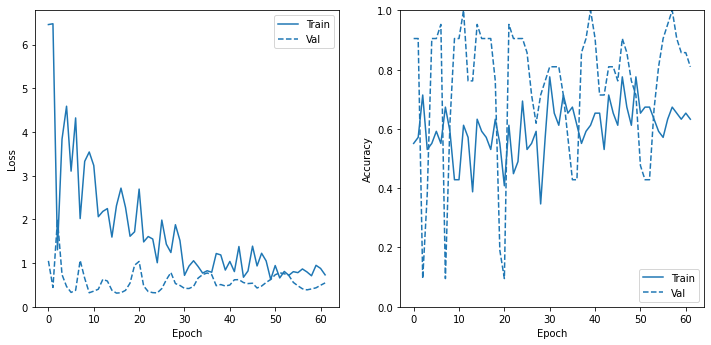

In [ ]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy']#, 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

### Predict and Classification Report

In [ ]:
from sklearn.metrics import classification_report

X_test = np.hstack((df_test['mfcc'].to_list(),
                    df_test['delta'].to_list(),
                    df_test['zcr'].to_list(),
                    df_test['lpc'].to_list()))
print(X_test.shape)
y_true = df_test['speaker']

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred = le.classes_[y_pred]
print(y_pred)
print(classification_report(y_true, y_pred, target_names=le.classes_))

(30, 52)
['id10087' 'id10087' 'id10087' 'id10087' 'id10060' 'id10087' 'id10087'
 'id10087' 'id10087' 'id10087' 'id10087' 'id10087' 'id10087' 'id10087'
 'id10087' 'id10087' 'id10060' 'id10087' 'id10060' 'id10060' 'id10087'
 'id10060' 'id10060' 'id10087' 'id10060' 'id10060' 'id10060' 'id10060'
 'id10060' 'id10060']
              precision    recall  f1-score   support

     id10060       0.67      0.89      0.76         9
     id10087       0.94      0.81      0.87        21

    accuracy                           0.83        30
   macro avg       0.81      0.85      0.82        30
weighted avg       0.86      0.83      0.84        30



## Gausian Mixture Model

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. A GMM attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.

A GMM uses an expectation–maximization approach which qualitatively does the following:

* Choose starting guesses for the location and shape

* Repeat until converged:

E-step: for each point, find weights encoding the probability of membership in each cluster

M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

In [ ]:
from sklearn import mixture
# fit a Gaussian Mixture Model with two components
# for every speaker fit a GMM and save the model
unique_speakers = df_train['speaker'].unique()
for speaker in unique_speakers:
    df_speaker = df_train[df_train['speaker'] == speaker]
    features = np.asarray(())
    for index, row in df_speaker.iterrows():
        vector = np.hstack((row['mfcc'], row['delta'], row['zcr'], row['lpc']))
        if features.size == 0:
            features = vector
        else:
            features = np.vstack((features,vector))
    
    gmm = mixture.GaussianMixture(n_components = 2, covariance_type='diag',n_init = 3)
    gmm.fit(features)    
    filename = 'saved_models/gmm/' + f'gmm_{speaker}.sav'
    pickle.dump(gmm, open(filename, 'wb'))
        


In [ ]:
# load models and predict on test
gmm_files = [os.path.join('saved_models/gmm/',fname) for fname in 
              os.listdir('saved_models/gmm/') if fname.endswith('.sav')]

#Load the Gaussian gender Models
gmm_models = [pickle.load(open(fname,'rb')) for fname in gmm_files]
unique_speakers   = [fname.split("/")[-1].split(".gmm")[0] for fname 
              in gmm_files]

print(unique_speakers)
nr_errors = 0
total_samples = len(df_test)
for index, row in df_test.iterrows():
    log_likelihood = np.zeros(len(gmm_models)) 
    features = np.hstack((row['mfcc'], row['delta'], row['zcr'], row['lpc']))
    features = features.reshape(1,-1)
    
    for i, gmm in enumerate(gmm_models):
        scores = np.array(gmm.score(features))
        log_likelihood[i] = scores.sum()

    y_pred = np.argmax(log_likelihood)
    if unique_speakers[y_pred] != 'gmm_' + row['speaker']+ '.sav':
        nr_errors += 1

accuracy = ((total_samples - nr_errors) / total_samples) * 100
print (f'The Accuracy with (MFCC + DELTA + ZCR) and GMM is : {accuracy}')


['gmm_id10429.sav', 'gmm_id10659.sav', 'gmm_id10482.sav', 'gmm_id10618.sav', 'gmm_id10261.sav', 'gmm_id10548.sav', 'gmm_id10564.sav', 'gmm_id10390.sav', 'gmm_id10769.sav', 'gmm_id10187.sav', 'gmm_id10718.sav', 'gmm_id10529.sav', 'gmm_id10734.sav', 'gmm_id10184.sav', 'gmm_id10547.sav', 'gmm_id10478.sav', 'gmm_id10617.sav', 'gmm_id10686.sav', 'gmm_id10706.sav', 'gmm_id10437.sav', 'gmm_id10757.sav', 'gmm_id10355.sav', 'gmm_id10181.sav', 'gmm_id10717.sav', 'gmm_id10237.sav', 'gmm_id10768.sav', 'gmm_id10657.sav', 'gmm_id10562.sav', 'gmm_id10436.sav', 'gmm_id10417.sav', 'gmm_id10491.sav', 'gmm_id10733.sav', 'gmm_id10236.sav', 'gmm_id10705.sav', 'gmm_id10475.sav', 'gmm_id10781.sav', 'gmm_id10544.sav', 'gmm_id10435.sav', 'gmm_id10590.sav', 'gmm_id10124.sav', 'gmm_id10716.sav', 'gmm_id10183.sav', 'gmm_id10235.sav', 'gmm_id10467.sav', 'gmm_id10354.sav', 'gmm_id10489.sav', 'gmm_id10767.sav', 'gmm_id10704.sav', 'gmm_id10635.sav', 'gmm_id10433.sav', 'gmm_id10542.sav', 'gmm_id10732.sav', 'gmm_id1047

ValueError: ignored

# Results



# Conclusions